<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/results/PAMPA_Solu_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [2]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet


In [3]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [ ]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *
from scripts.TRAIN import *
print('VOCAB TYPE:', VOCAB_TYPE)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

def process_ensemble_v1(tst, folder_name='T3/uw',
                        model_dict={
                            'MLP': 1,
                            'AttentiveFP':2,
                            'GIN':1,
                            'RNN':1
                        }):
    task_names = tst.columns.tolist()
    # print('col names', col_names)
    task_names.remove('Drug')
    print('task names',task_names)
    df_list = []
    for i in range(len(task_names)):
        # print(i, M5[i])

        # append true labels into df_list
        temp_df = pd.DataFrame()
        temp_df['Drug'] = tst['Drug'].tolist()
        temp_df[task_names[i]] = tst[task_names[i]].tolist()
        df_list.append(temp_df)

    for model_type, model_num in model_dict.items():
        file_name = f'{folder_name}/{model_type}_MT_{model_num}.yml'
        with open(file_name, 'r') as f: yml_data = yaml.safe_load(f)
        models = PRED(**yml_data['config'])
        models.load_status(yml_data)

        df = models.predict(tst['Drug'].tolist(), return_probs=True)
        for j in range(len(task_names)):
            df_list[j][model_type] = df[task_names[j]].tolist()
    return df_list


class ensemble_dataset(Dataset):
    def __init__(self, df, task_name, mask=MASK,
                 header=['MLP', 'AttentiveFP', 'GIN', 'RNN']):
        super(ensemble_dataset, self).__init__()

        self.df = df.copy().fillna(mask)
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[[task_name]]
    def __len__(self): return self.len
    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

# Evaluation on PAMPA, a dataset that is highly imbalanced.

## Therefore, weighted accuracy is a better metrics to evaluate performance

Found local copy...
Loading...
Done!


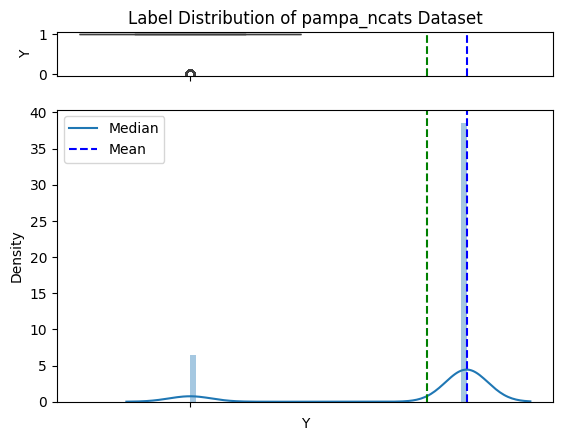

In [8]:
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
name = 'PAMPA_NCATS'
data = ADME(name=name)
data.label_distribution()

## Single task, the results for all 4 algorithms MLP, ATP, GIN, RNN

In [11]:
folder_name = f'ST/{name}/'
d_metrics= {'reg': [0,2,3], 'cls': [0,1,6,8]}
for model_type in ['MLP', 'AttentiveFP', 'GIN', 'RNN']:
    print('\n','='*30, model_type, '='*30)
    perfs = []
    for i in range(3):
        file_name = folder_name + model_type + '_ST_' + str(i) + '.yml'
        p = yml_report(file_name)
        perfs.append(p)
    eval_perf_list(perfs, name, metrics_dict=d_metrics)


 ============================== MLP ==============================
repeated num # 3 idx 1 has the lowest loss
******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.852$\pm$0.005  &0.560$\pm$0.043  &0.764$\pm$0.009  &0.940$\pm$0.005  
 idx 1: &0.855            &0.584            &0.777            &0.946            


 ============================== AttentiveFP ==============================
repeated num # 3 idx 2 has the lowest loss
******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.841$\pm$0.008  &0.575$\pm$0.029  &0.750$\pm$0.002  &0.925$\pm$0.003  
 idx 2: &0.837            &0.537            &0.751            &0.922            


 ============================== GIN ==============================
repeated num # 3 idx 2 has the lowest loss
******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |  

### On single task, the best performance is GIN

In [13]:
print('GIN 3 time results')
model_type = 'GIN'
for i in range(3):
    file_name = folder_name + model_type + '_ST_' + str(i) + '.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})

GIN 3 time results
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.867   &0.636   &0.884   &0.971   &0.302   &0.925   &0.772   &0.383   &0.941   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.872   &0.678   &0.897   &0.959   &0.397   &0.927   &0.781   &0.438   &0.942   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.867   &0.636   &0.884   &0.971   &0.302   &0.925   &0.782   &0.383   &0.944   


Found local copy...
Loading...
Done!


collect data for:  ['PAMPA_NCATS']
--> preparing data loader for model type  GIN


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 68.2MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978733
finish load data status 

load pretrained model from  ST/PAMPA_NCATS/GIN_ST_1.pt
[Test] Loss: 0.349
*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.872  &0.678  &0.897  &0.959  &0.397  &0.927 &0.781 &0.438 &0.942


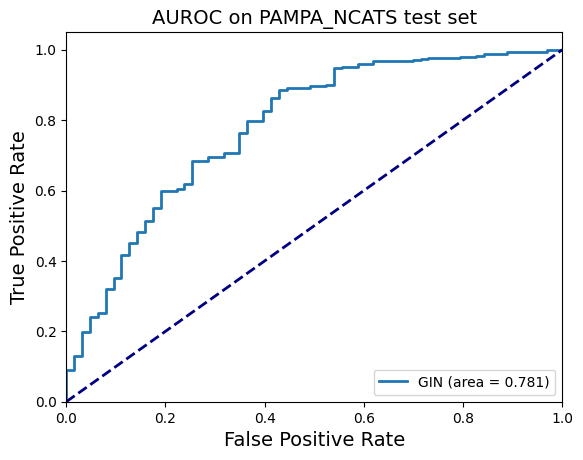

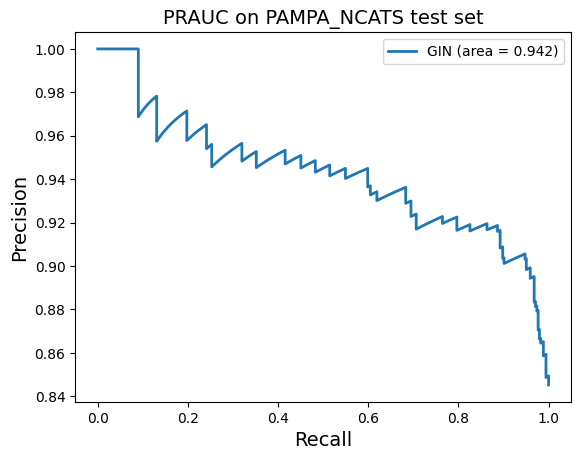

In [34]:
name = 'PAMPA_NCATS'
model_type = 'GIN'
folder_name = f'ST/{name}'
i = 1

file_name = f'{folder_name}/{model_type}_ST_{i}.yml'
p_ST_PAM = yml_report(file_name, recalculate=True, return_all=True)


## For MUE, the selection of multi-task to train together affects the final results.

#### E.g., train absorption and distribution tasks together, performance will be slightly worse than only train on absorption tasks.

`MUE on AD tasks:  ['BBB_Martins', 'PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']`

In [17]:
print('MUE on AD tasks: ', names_AD)
perfs = []
for i in range(3):
    file_name = f'AD_mix/uw/MUE_{name}_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})
    perfs.append(p)
print('\n\n')
best_idx = eval_perf_list(perfs, name, metrics_dict=d_metrics)

MUE on AD tasks:  ['BBB_Martins', 'PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.870   &0.664   &0.892   &0.962   &0.365   &0.926   &0.819   &0.417   &0.958   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.860   &0.554   &0.860   &0.997   &0.111   &0.923   &0.822   &0.282   &0.958   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.845   &0.500   &0.845   &1.000   &0.000   &0.916   &0.821   &nan   &0.958   



repeated num # 3 idx 0 has the lowest loss
******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.858$\pm$0.010  &0.573$\pm$0.068  &0.821$\pm$0.001  &0.958$\p

`MUE on Absorption tasks only:  ['PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']`


In [19]:
print('MUE on Absorption tasks only: ', names_A3)
perfs = []
for i in range(3):
    file_name = f'A3/uw/MUE_{name}_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})
    perfs.append(p)
print('\n\n')
best_idx = eval_perf_list(perfs, name, metrics_dict=d_metrics)

MUE on Absorption tasks only:  ['PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.882   &0.703   &0.904   &0.962   &0.444   &0.932   &0.827   &0.489   &0.958   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.885   &0.698   &0.902   &0.968   &0.429   &0.934   &0.821   &0.493   &0.954   
******************** PAMPA_NCATS ******************** 
	|  acc  |  w_acc  |  prec  |  recall  |  sp  |  f1  |  auc  |  mcc  |  ap  
single: &0.882   &0.697   &0.902   &0.965   &0.429   &0.933   &0.817   &0.484   &0.953   



repeated num # 3 idx 1 has the lowest loss
******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       auc      |       ap      
	&0.883$\pm$0.001  &0.699$\pm$0.003  &0.822$\pm$0.004  &0.955$\p

# Solubility evaluation

## Single task

Found local copy...
Loading...
Done!


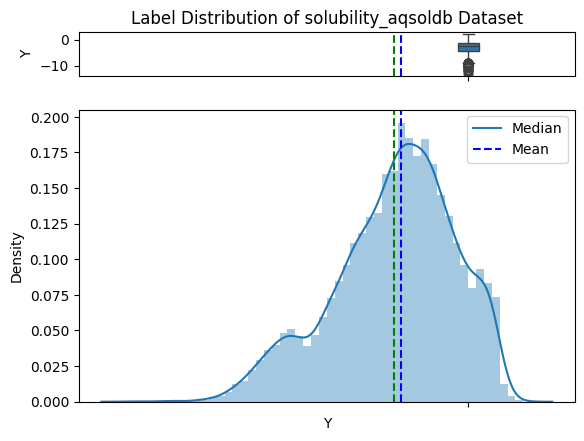

In [24]:
name = 'Solubility_AqSolDB'
data = ADME(name=name)
data.label_distribution()

In [22]:
folder_name = f'ST/{name}/'
d_metrics= {'reg': [0,2,3], 'cls': [0,1,6,8]}
for model_type in ['MLP', 'AttentiveFP', 'GIN', 'RNN']:
    print('\n','='*30, model_type, '='*30)
    perfs = []
    for i in range(3):
        file_name = folder_name + model_type + '_ST_' + str(i) + '.yml'
        p = yml_report(file_name)
        perfs.append(p)
    eval_perf_list(perfs, name, metrics_dict=d_metrics)


 ============================== MLP ==============================
repeated num # 3 idx 1 has the lowest loss
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.935$\pm$0.012  &1.286$\pm$0.016  &0.695$\pm$0.008  
 idx 1: &0.918            &1.273            &0.701            


 ============================== AttentiveFP ==============================
repeated num # 3 idx 1 has the lowest loss
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.688$\pm$0.004  &1.005$\pm$0.007  &0.814$\pm$0.003  
 idx 1: &0.683            &0.996            &0.817            


 ============================== GIN ==============================
repeated num # 3 idx 2 has the lowest loss
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.805$\pm$0.022  &1.136$\pm$0.025  &0.762$\pm$0.010  
 idx 2: &0.773    

## AttentiveFP has the best performance on solubility task

In [25]:
model_type = 'AttentiveFP'
for i in range(3):
    file_name = folder_name + model_type + '_ST_' + str(i) + '.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})

******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.694   &1.016   &1.008   &0.813   
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.683   &0.991   &0.996   &0.817   
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.688   &1.024   &1.012   &0.811   


#### Single task, attentive FP on Solubility

[Test] Loss: 0.004
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.683  &0.991  &0.996  &0.817


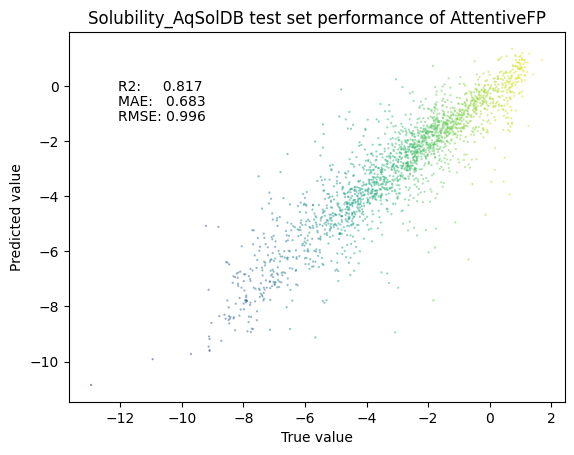

In [48]:
task_name = 'Solubility_AqSolDB'
model_type = 'AttentiveFP'
i = 1
file_name = f'ST/{task_name}/{model_type}_ST_{i}.yml'
p = yml_report(file_name, recalculate=True)

### Similarly, MUE performs better if trained on absorption tasks only.

In [28]:
print('MUE on AD tasks: ', names_AD)
perfs = []
for i in range(3):
    file_name = f'AD_mix/uw/MUE_{name}_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})
    perfs.append(p)
print('\n')
best_idx = eval_perf_list(perfs, name, metrics_dict=d_metrics)

print('\n\n\n')
print('MUE on Absorption tasks only: ', names_A3)
perfs = []
for i in range(3):
    file_name = f'A3/uw/MUE_{name}_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], name, metrics_dict={})
    perfs.append(p)
print('\n\n')
best_idx = eval_perf_list(perfs, name, metrics_dict=d_metrics)

MUE on AD tasks:  ['BBB_Martins', 'PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.714   &1.006   &1.003   &0.815   
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.705   &0.992   &0.996   &0.817   
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  
single: &0.706   &0.985   &0.993   &0.818   


repeated num # 3 idx 2 has the lowest loss
******************** Solubility_AqSolDB ******************** 
	|       mae      |       rmse      |       r2      
	&0.709$\pm$0.004  &0.997$\pm$0.004  &0.817$\pm$0.002  
 idx 2: &0.706            &0.993            &0.818            





MUE on Absorption tasks only:  ['PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']
******************** Solubility_AqSolDB ******************** 
	|  mae  |  mse  |  rmse  |  r2  

### Generate figures for PAMPA and Solubility tasks

In [ ]:
names = names_AD
folder_name  = 'AD_mix/uw'
model_dict={'MLP': 1,
            'AttentiveFP':1,
            'GIN':2,
            'RNN':1
            }
repeat_time = 3
retrain = False

trn, val, tst = collect_data(names)

trn_list = process_ensemble_v1(trn, folder_name, model_dict)
val_list = process_ensemble_v1(val, folder_name, model_dict)
tst_list = process_ensemble_v1(tst, folder_name, model_dict)

Model type:  MUE | Model parameters:  2945
finish load data status 

load pretrained model from  AD_mix/uw/MUE_PAMPA_NCATS_0.pt
[Test] Loss: 0.045
*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.870  &0.664  &0.892  &0.962  &0.365  &0.926 &0.819 &0.417 &0.958


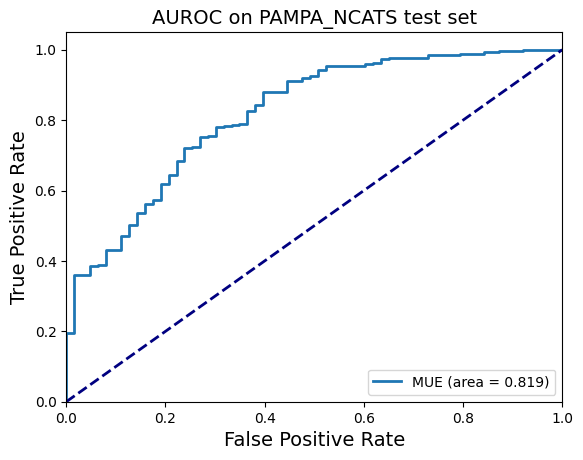

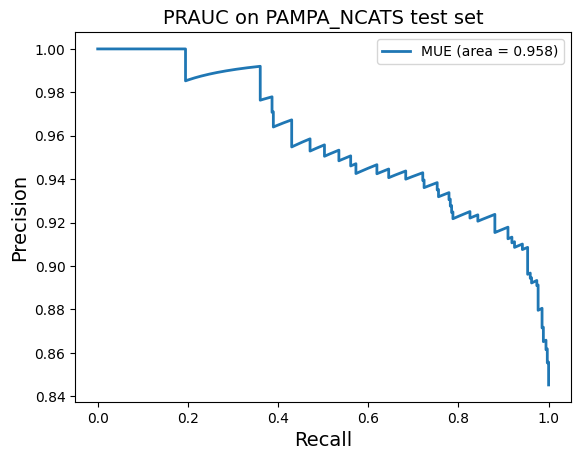

In [37]:
import yaml

task_name = 'PAMPA_NCATS'
task_num = 1
i = 0
folder_name = 'AD_mix/uw'
config_path = folder_name + '/MUE_' + task_name  + '_' +  str(i) + '.yml'

with open(config_path, 'r') as f: data = yaml.safe_load(f)
config = data['config']
batch_size = config['batch_size']
params_ = {'batch_size': batch_size, 'shuffle': True,
                'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}


trn_l = DataLoader(ensemble_dataset(trn_list[task_num], task_name), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], task_name), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], task_name), **param_t)

models = PRED(**config)
models.load_status(data)
p_MUE_AD_PAMPA = models.eval(tst_l)

## Solubility, MUE, on AD tasks

Model type:  MUE | Model parameters:  2945
finish load data status 

load pretrained model from  AD_mix/uw/MUE_Solubility_AqSolDB_2.pt
[Test] Loss: 0.829
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.706  &0.985  &0.993  &0.818


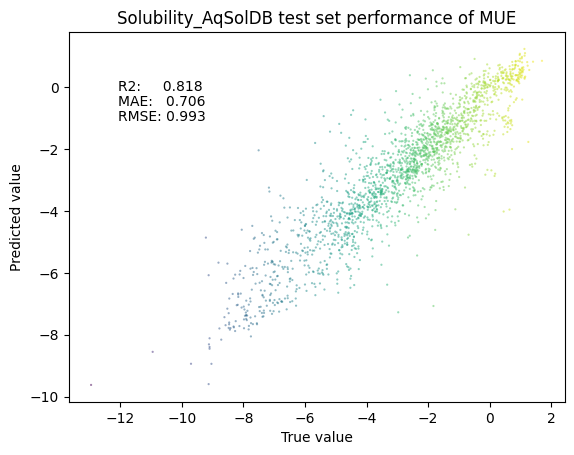

In [39]:
task_name = 'Solubility_AqSolDB'
task_num = 3
i = 2
folder_name = 'AD_mix/uw'
config_path = folder_name + '/MUE_' + task_name  + '_' +  str(i) + '.yml'

with open(config_path, 'r') as f: data = yaml.safe_load(f)
config = data['config']
batch_size = config['batch_size']
params_ = {'batch_size': batch_size, 'shuffle': True,
                'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}


trn_l = DataLoader(ensemble_dataset(trn_list[task_num], task_name), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], task_name), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], task_name), **param_t)

models = PRED(**config)
models.load_status(data)
p_MUE_AD_SOLU = models.eval(tst_l)

In [ ]:
names = names_A3
folder_name  = 'A3/uw'
model_dict={'MLP': 1,
            'AttentiveFP':1,
            'GIN':1,
            'RNN':1
            }
repeat_time = 3
retrain = False

trn, val, tst = collect_data(names)

trn_list = process_ensemble_v1(trn, folder_name, model_dict)
val_list = process_ensemble_v1(val, folder_name, model_dict)
tst_list = process_ensemble_v1(tst, folder_name, model_dict)

In [42]:
names_A3

['PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']

Model type:  MUE | Model parameters:  2945
finish load data status 

load pretrained model from  A3/uw/MUE_PAMPA_NCATS_0.pt
[Test] Loss: 0.046
*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.882  &0.703  &0.904  &0.962  &0.444  &0.932 &0.827 &0.489 &0.958


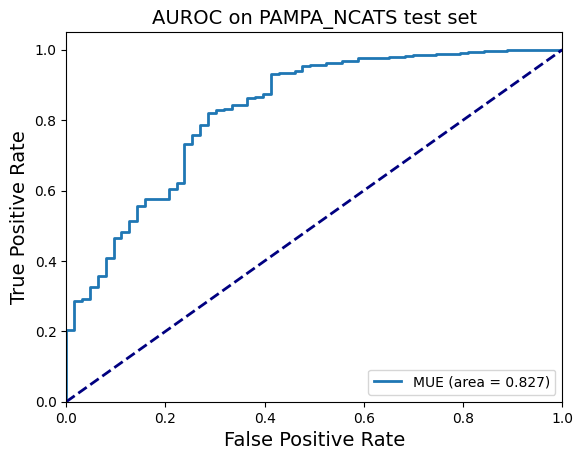

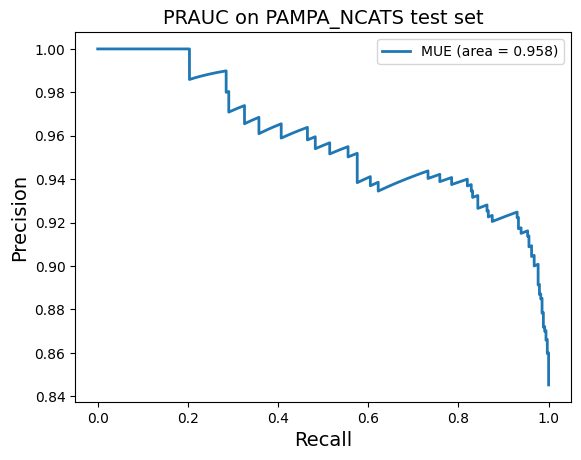

In [43]:
task_name = 'PAMPA_NCATS'
task_num = 0
i = 0
folder_name = 'A3/uw'
config_path = folder_name + '/MUE_' + task_name  + '_' +  str(i) + '.yml'

with open(config_path, 'r') as f: data = yaml.safe_load(f)
config = data['config']
batch_size = config['batch_size']
params_ = {'batch_size': batch_size, 'shuffle': True,
                'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}


trn_l = DataLoader(ensemble_dataset(trn_list[task_num], task_name), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], task_name), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], task_name), **param_t)

models = PRED(**config)
models.load_status(data)
p_MUE_A_PAMPA = models.eval(tst_l)

## Solubility MUE, trained on Absorption task only

Model type:  MUE | Model parameters:  2945
finish load data status 

load pretrained model from  A3/uw/MUE_Solubility_AqSolDB_2.pt
[Test] Loss: 0.837
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.676  &0.920  &0.959  &0.830


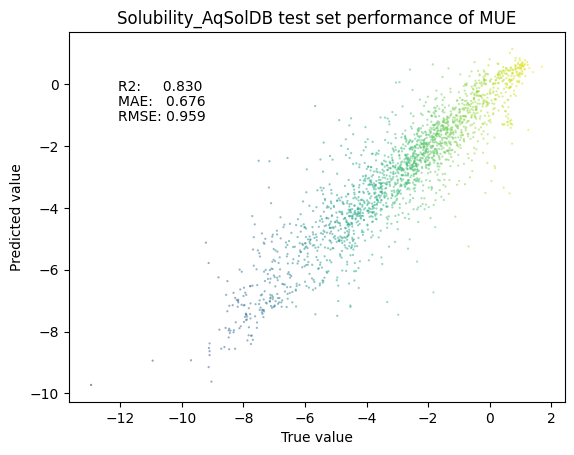

In [44]:
task_name = 'Solubility_AqSolDB'
task_num = 2
i = 2
folder_name = 'A3/uw'
config_path = folder_name + '/MUE_' + task_name  + '_' +  str(i) + '.yml'

with open(config_path, 'r') as f: data = yaml.safe_load(f)
config = data['config']
batch_size = config['batch_size']
params_ = {'batch_size': batch_size, 'shuffle': True,
                'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}


trn_l = DataLoader(ensemble_dataset(trn_list[task_num], task_name), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], task_name), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], task_name), **param_t)

models = PRED(**config)
models.load_status(data)
p_MUE_A_SOLU = models.eval(tst_l)

## PAMPA overall figure for AUC and AP

In [45]:
names_A3

['PAMPA_NCATS', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB']

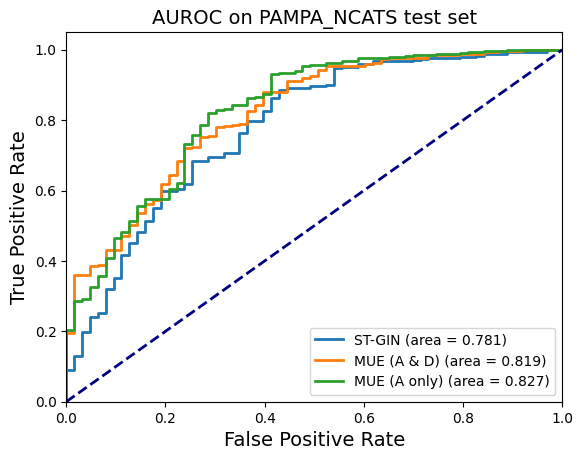

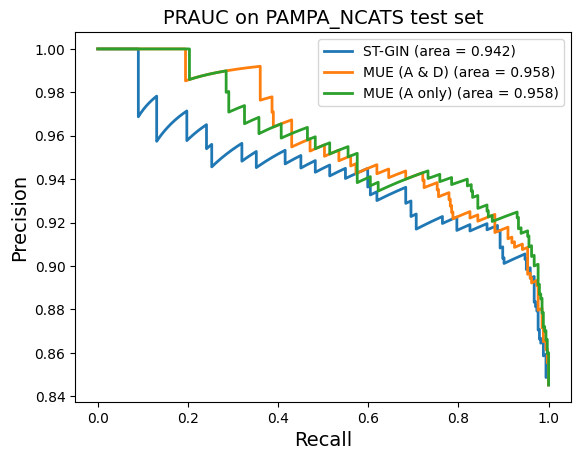

In [50]:
task_name = 'PAMPA_NCATS'
probs_list = []
label_list = []
model_list = []
model_type = 'GIN'
probs_list.append(p_ST_PAM[1][task_name]) # single task, probability
label_list.append(p_ST_PAM[2][task_name])
model_list.append(f'ST-{model_type}')
# import numpy as np
# roc_curve(np.array(p_ST[1][task_name]), np.array(p_ST[2][task_name]),
#           method_name=f'{model_type}')

probs_list.append(p_MUE_AD_PAMPA[1][task_name])
label_list.append(p_MUE_AD_PAMPA[2][task_name])
model_list.append(f'MUE (A & D)')
probs_list.append(p_MUE_A_PAMPA[1][task_name])
label_list.append(p_MUE_A_PAMPA[2][task_name])
model_list.append(f'MUE (A only)')

roc_curve_batch(probs_list, label_list, model_list, figure_title=f'{task_name}')
prc_curve_batch(probs_list, label_list, model_list, figure_title=f'{task_name}')
